## An introduction to heterogeneous agents models in dolo

#### An incomplete markets model with idiosyncratic income risk

**James Graham** *New York University, Bank of England*

September 2016

In [1]:
# Setup
import numpy as np

from dolo import yaml_import, pcat
from dolo.algos.time_iteration import time_iteration #, time_iteration_direct
from dolo.algos.improved_time_iteration import improved_time_iteration 
time_iteration_direct = improved_time_iteration # temp compat fix
from dolo.algos.simulations import plot_decision_rule
from heterogeneous_agents import stat_dist, solve_eqm, supply_demand, fine_grid

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

    The distributions module is experimental. Please report any errors you may encounter during use to the EconForge/dolo issue tracker.


In this notebook, I show how to build and solve a simple heterogeneous agents model using the dolo language. The model used is a simple incomplete markets model with idiosyncratic income fluctations, as in Aiyagari (1994). We look for a stationary equilibrium in the economy, and do not consider aggregate uncertainty. I focus on explaining how we build such a model in the dolo framework, and what can be done with the model once built.

### Model

*Households*:  The economy consists of a continuum of households $i \in [0,1]$ that are identical ex-ante, but differ due to idiosyncratic fluctuations in labor income (i.e. idiosyncratic labor productivity). A household's problem is

$$ \underset{\{c_t^i, k_{t+1}^i\}_{t=0}^{\infty}}{\max} E_0 \sum_{t=0}^{\infty} \beta^t \frac{(c_t^i)^{1-\sigma} - 1}{1 - \sigma} \\
\textrm{s.t.} \quad c_t^i + k_{t+1}^i = r_t k_t^i + \bar{l} e_t^i w_t + (1-\delta) k_t^i \\
\quad k_{t+t}^i \geq 0 $$

Households choose consumption, $c_t^i$, and capital holdings, $k_{t+1}^i$, subject to the budget constraint and a no-borrowing constraint on capital. $\bar{l}$ reflects the permanent component of labor productivity, while $e_t^i$ is an idiosyncratic shock.

The Aiyagari model is often presented with a two-state Markov process for idiosyncratic income, e.g. $e_t^i \in \{e_l, e_h \}$. Here, I allow for more general processes, in particular, I'm interested in allowing the log of $e_t^i$ to follow an AR(1): $ \ln e_t^i = \rho \ln e_{t-1}^i + \varepsilon_t^i $, with $\varepsilon_t^i \sim \mathcal{N}(0, \sigma_e^2)$. 

*Firms*: Output is produced by perfectly competitive firms using labor and capital as inputs. The production function for a firm is Cobb-Douglas, which generates a wage and interest rate from the firm's first order conditions: 

$$ w_t = (1-\alpha) \left(\frac{K_t}{L_t} \right)^{\alpha} \\
r_t = \alpha \left(\frac{K_t}{L_t} \right)^{\alpha - 1} $$

*Equilibrium*: A stationary equilibrium consists of prices ${w, r}$, decision rules for households $\{c(k, e; r, w), k'(k, e; r, w) \}$, decision rules for firms $\{K(r,w), L(r,w) \}$, a distribution of households $\lambda(k, e)$, and a transition function for the distribution $Q_{k, e, k', e'}$ such that:
- Given prices, the household's decision rules solve the household problem
- Given prices, the firm's decision rules solve its profit maximization problem
- The market for capital clears: $K(r,w) = \int k'(k, e; r, w) d\lambda(k, e) $
- The market for labor clears: $L(r,w) = \int \bar{l} e d\lambda(k, e) $
- The distribution is stationary: $\lambda = Q \lambda$

*Notes* I make a set of simplifying assumptions about labor supply and the idiosyncratic labor process. First, since by a law of large numbers, aggregate labor supply is constant, I can normalize $L$ to 1 (note: there are technical problems associated with this law of large numbers argument. See Judd (1985)). To ensure that market clearing holds, note that under the log-AR(1) assumption, $\ln e$ is unconditionally normally distributed: $\ln e \sim \mathcal{N}(0, \frac{\sigma_e^2}{1 - \rho^2})$. By the properties of log-normal variables, the unconditional mean of $e$ is $\exp(\frac{1}{2}\frac{\sigma_e^2}{1-\rho^2})$. From the market clearing condition, we thus have the relationship:
$$ \sigma_e^2 = 2(1-\rho^2) \ln \left(  \frac{1}{\bar{l}} \right) $$
Thus, we can change either the persistence or variance of the idiosyncratic process without affecting aggregate labor supply simply by changing the scaling constant $\bar{l}$. 










### Solving the model with dolo

First, we need to write the model into a yaml file format. Second, we choose a solution method. Dolo has several methods for solving the decision rules of an agent's problem, but here I focus on the Time Iteration method (e.g. see Rendhal (EJ, 2015)). 

Our yaml file will centre around the `arbitrage` equation in the model. This is, essentially, the optimality condition for the model. We write the Euler equation of the household's problem:

$$ c_t^{-\sigma} \geq \beta E_t (c_{t+1}^{-\sigma}(1 + r - \delta)) \\
\textrm{With strict equality when} \quad k_{t+1} > 0 \\
\textrm{With strict inequality when} \quad k_{t+1} = 0 $$

We then write this into the `arbitrage` equation with associated complementarity condition in the yaml model file. It will also be useful for our purposes to write the RHS of the Euler equation as a function, $m$, and write consumption as a direct function of $m$. This representation is written into the `expectation` and `direct_response` sections of the yaml file. 

Here I use a `dtcscc` model (i.e. discrete time continuous state continuous control), set the state space for capital to between 0 and 150, use a normal distribution for the shocks to employment productivity, and set the state space for employment productivity to minus/plus 3 times the unconditional standard deviation of the log-AR(1) process. The default in dolo is to use cubic splines to approximate model functions.

After writing the yaml file, we can load it with the `yaml_import` command, and display it in the notebook with the `pcat` command below.

In [2]:
filename = 'incomplete_markets_dtcscc.yaml'
model = yaml_import(filename)
pcat(filename)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54


### Solving for decision rules

For the most part, the yaml model file describes the model components required to solve for the household's decision rule. This decision rule is dependent on the prices $r, w$, which are determined by the aggregate variables $K, L$. As noted above, the idiosyncratic labor productivity process is such that $L = 1$ ($L$ is denoted by $lagg$ in the yaml file). However, aggregate capital depends on the cross sectional distribution of agents $\lambda(k, e)$. Because the cross sectional distribution is not known in advance, in the yaml file we assume a given level of aggregate capital, e.g. $K = 50$. Prices are then pinned down by the aggregate varaibles, and the decision rule can be solved. 

Here, the household's decision rule is solved using the `time_iteration_direct` method. This method requires that the arbitrage equation can be rewritten so that the model's control(s) can be written as direct functions of the expectation in the arbitrage equation (see the `expectation` and `direct_response` sections of the yaml file, above). 

`time_iteration_direct` produces a decision rule object, which contains information about the state space grid, the interpolation type used in the function appproximation, and the solved decision rule itself. We make sure to solve the model using argument `with_complementarities` so that the no-borrowing constraint faced by the household is respected. We can also toggle `verbose` to observe convergence output from the algorithm.

In [4]:
sol = improved_time_iteration(model, verbose=False)
dr = sol.dr

Because the `time_iteration_direct` method solves for the controls as direct functions of the expectation function, there is no optimization/minimization step involved in finding the control. This speeds up computation relative to other methods. For example:

In [4]:
%timeit time_iteration_direct(model,  maxit=1000, verbose=False)

475 ms ± 7.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%timeit time_iteration(model, maxit=1000, verbose=False)

4.06 s ± 247 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can easiy plot the decision rule for the solved model using `plot_decision_rule`. To do so, we specify the state variable over which we want to plot the decision rule via argument `state`, in this case $k$. We specificy the control variable of interest via argument `plot_controls`, in this case $c$. Note, we can also plot the implicit decision rule for the capital choice, as shown below.  We set `n_steps` to 100 to get a smooth interpolation over the state space. Finally, the `s0` argument allows us to vary the value of the employment productivity state, allowing us to plot the decision rule over the capital state space for different values of employment productivity. 


In [5]:
%matplotlib inline

egrid = np.unique(dr.endo_grid.nodes()[:,0])
kss = model.calibration['states'][1]

plt.figure(figsize=(15, 7.5))
plot_decision_rule(model, dr, state='k', plot_controls='c', n_steps=100, s0=np.array([egrid[0], kss]), label='e_1', linewidth=2,) 
plot_decision_rule(model, dr, state='k', plot_controls='c', n_steps=100, s0=np.array([egrid[3], kss]), label='e_4', linewidth=2,)
plot_decision_rule(model, dr, state='k', plot_controls='c', n_steps=100, s0=np.array([egrid[5], kss]), label='e_6', linewidth=2,)
plt.ylabel('$c_t$')
plt.xlabel('Capital, $k_t$')
plt.title('Consumption')
plt.legend(loc='best')

TypeError: plot_decision_rule() got multiple values for argument 'plot_controls'

<Figure size 1080x540 with 0 Axes>

### Solving for a stationary distribution

It is useful to know the distribution of households for any given level of aggregate capital. We compute this distribution as the supposed ''stationary distribution'' if the aggregate level of capital were held at that level for all time. Of course, for almost all values of aggregate capital, the market for capital will not clear. So the distribution that is computed here is *not* the stationary distribution associated with equilibrium in the economy. 

We compute the distribution via a discretization/histogram method described in Young (JEDC, 2010). First, we construct a fine grid for the state space, which uses the same bounds we used to solve the household's decision rule, but with many more points. This produces a discrete state space over $(k, e)$ points on which we define the discrete density $\lambda$.  

Next, we solve for the discrete density. Suppose at some date $t$ we have a density $\lambda_t$, which is represented by a vector, where each element of the vector $\lambda_{t}(i)$ reflects a $(k,e)$ pair in the state space. Now the density transition function $Q_{k,e,k',e'}$ is represented as a matrix $Q$. An element of the matrix $Q_{i,j}$ describes the probability of moving from a point $(k,e)_i$ to $(k,e)_j$. We can update the density via:

$$ \lambda_{t+1} = Q^T \lambda_{t}$$

where $Q^T$ is the transpose of the transition matrix. We find the stationary distribution by iterating on this transition equation until convergence: $ \lambda = Q^T \lambda $.

(See the documentation for details about the construction of the transition matrix.)

### Computing the stationary distribution in dolo

First, we define the fine grid on which we will solve for distribution objects. I use 500 points for the capital state space, and 15 points for the idiosyncratic productivity space (i.e we are using 15 states for the Rouwenhorst discretization of the AR(1)). We can produce the fine grid using the function `fine_grid`.

We can compute the stationary distribution in dolo with the single command, `stat_dist`. It takes as arugments: the model object, the solved decision rule, the array of numbers of fine grid points, the maximum number of iterations over the transition equation, a verbosity toggle. 

In [6]:
Nf = np.array([15, 500])

gridf = fine_grid(model, Nf)

L, QT = stat_dist(model, dr, Nf, itmaxL=5000, verbose=True)


Iteration = 0, dist = 0.496383 

Iteration = 100, dist = 0.006494 

Iteration = 200, dist = 0.001723 

Iteration = 300, dist = 0.000315 

Iteration = 400, dist = 0.000054 

Iteration = 500, dist = 0.000009 

Iteration = 600, dist = 0.000002 

Iteration = 700, dist = 0.000000 

Iteration = 800, dist = 0.000000 



Note that the computation of the stationary distribution is very quick. This is in stark contrast to other methods, such as those that require a large panel simulation of agents in the model. 

In [7]:
%timeit stat_dist(model, dr, Nf, itmaxL=5000, verbose=False)

716 ms ± 918 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
from dolo.algos.simulations import simulate
%time sim = simulate(model, dr, N=100000, T=200)


CPU times: user 199 ms, sys: 46 µs, total: 199 ms
Wall time: 32.4 ms


In [9]:
import seaborn
simulated_data = sim.sel(V=['e','k'], T=199)
seaborn.jointplot(x="e", y="k", data=df);
df = simulated_data.to_pandas()

NameError: name 'df' is not defined

The function `stat_dist` returns the denisty, here denoted $L$, and the transpose of the transition matrix, dentoed $QT$. The function `fine_grid` returns an array of length `Nf[0]*Nf[1]`, which is ordered as $(k, e)$ (note that the first column moves slowest, the second column fastest). We can now compute the aggregated level of capital holdings in this stationary distribution:    

In [ ]:
kaggregated = np.dot(gridf[:,1], L)
kaggregated

We can see that aggregated capital holdings are much lower than the guess for aggregate capital (26 vs. 50). This means that our guess for capital is too high, and we will need to vary that guess until it is consistent with aggregated capital holdings. 

Before moving on, note that because the density is across two state variables only, it is possible to plot the density. I do this using a 3D mesh plot of the density, and a filled contour plot. We can see that given an aggregate level of capital equal to 50, iinterest rates are low enough than many households find themselves on or very near to the borrowing constraint, $k=0$. The figures show that for any given level of capital, there is a long right-tail in employment productivity. This reflects the fact that employment productivity is distributed log-normally.

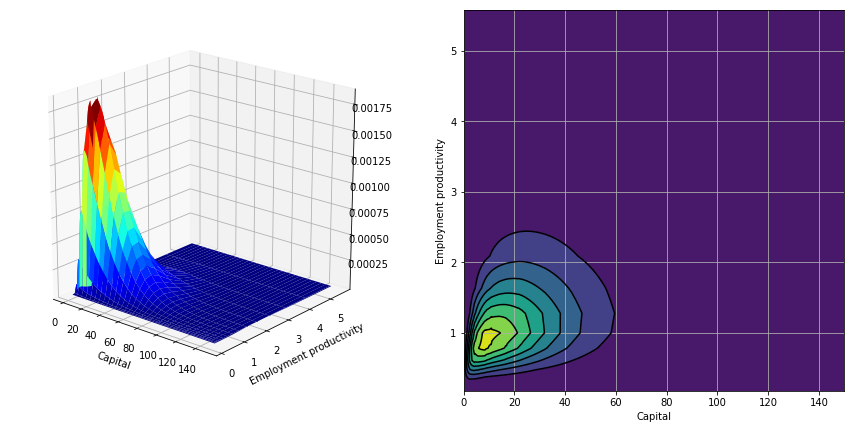

In [10]:
# 3D plot of the distribution
Z = L.reshape([Nf[0], Nf[1]])
egridf = np.unique(gridf[:,0])
kgridf = np.unique(gridf[:,1])
X, Y = np.meshgrid(kgridf, np.exp(egridf))

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=15, cmap = cm.jet)
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
ax.elev = 20
ax.azim = 310

# Contour plot
ax = fig.add_subplot(122)
contour = plt.contour(X, Y, Z, colors='k')
cp = plt.contourf(X, Y, Z)
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
plt.grid()

### Exploring the demand and supply for capital

In this economy, households hold capital as an asset and so are suppliers of capital (recall that households cannot borrow against capita so gross and net capital holdings are the same). Firms use capital in the production process and so generate demand for capital. A stationary equilibrium is such that the supply of capital equals its demand. 

As we saw above, it is straightforward to compute the stationary density associated with any guess for aggregate capital (i.e. demand), and then find the aggregated capital (i.e. supply). We can trace out these supply and demand curves with one function call, using `supply_demand`. It takes as arguments, the model object, a string for the name of the household's variable that is to be aggregated, a string for the name of the aggregate capital guess, the name of the price associated with these variables (i.e. the interest rate), the number of fine grid points, the lower and upper bounds on guesses for the aggregate variable, the number of points on each of the supply and demand graphs to be plotted, and a toggle for verbosity. 

The function returns capital demand, capital supplied, and the interest rate associated with capital demanded. 

Note that we need to be careful with the choice of lower and upper bounds on $K$, as the supply function may not be well behaved for all possible values. For example, when $K$ is very low, the interest rate can be higher than the interest rate that holds in the steady state of the representative agent model, which can generate explosive solutions. Usually, we will want to ensure that $\beta (1 + r - \delta) < 1$.

I call the `supply_demand` and plot the resulting supply and demand curves below.

Importantly, we can see that the supply of capital is well behaved around the implied equilibrium, so it should be straightfoward to find this equilibrium.

In [11]:
bounds = [40, 60]
varname = 'k'
aggvarname = 'kagg'
pricename = 'r'

Kd, Ks, r = supply_demand(model, varname, aggvarname, pricename, Nf, bounds, numpoints=30, verbose=True)

Iteration = 	0
Iteration = 	5
Iteration = 	10
Iteration = 	15
Iteration = 	20
Iteration = 	25


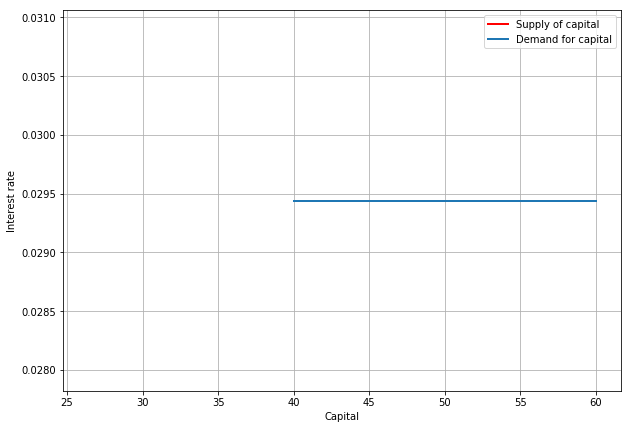

In [12]:
%matplotlib inline

fig = plt.figure(figsize=(10, 7))
plt.plot(Ks, r,label='Supply of capital', linewidth=2, color='red')
plt.plot(Kd, r,label='Demand for capital', linewidth=2)
plt.xlabel('Capital')
plt.ylabel('Interest rate')
plt.legend(loc='best')
plt.grid()

### Solving for the stationary equilibrium

Having explored the supply and demand for capital in the model, we now have reasonable bounds to place on the guess for aggregate capital in order to solve for the equilibrium directly (rather than visually). Dolo provides several methods for solving for the equilibrium:
- `damping`:
    - By computing the value of aggregated capital for any given guess, damping updates the guess by a slow-moving linear combination of the guess and the computed value, i.e. $K_{s+1} = \phi K_{s} + (1-\phi) K^{agg}_{s}$. This method is very stable when the supply function is not well behaved. However, it is slower than the other methods:
- `bisection`:
    - By computing the residual $K_{s} - K^{agg}_{s}$ (i.e. excess demand) at the upper bound, lower bound, and mid-point of an interval, bisection successively shrinks the interval around equilibrium. May be unstable when the supply function is not well behaved. However, faster than damping:  
- Brent's method (`brent`):
    - Also uses the excess demand residual. Combines the bisection method, the secant method, and inverse quadratic interpolation method. See the wikipedia page and the `scipy.optimize` documentation for details. Faster than either of the previous two methods: 
- Ridder's method (`ridder`):
    - See the Wikipedia page and the `scipy.optimize` documentation for details. Similar performance to Brent's method: 

the `solve_eqm` function takes as arguments: the model object, the array of numbers for the fine grid points, the name of the household's variable to be aggregated, the name of the aggregate variable to be solved for, the bounds on the space to be searched for the equilibrium value of capital, the algorithm to be used, a verbosity toggle (and option arguments for the tolerance on the solution and the maximum number of iterations to be run). 

I run each of the methods below, each of which generates similar values for the equilibrium value of capital. 

In [13]:
K = solve_eqm(model, Nf, varname, aggvarname, bounds, method='damping', verbose=False)
K

26.415389364293084

In [14]:
K = solve_eqm(model, Nf, varname, aggvarname, bounds, method='brent', verbose=False)
K

ValueError: f(a) and f(b) must have different signs

In [ ]:
K = solve_eqm(model, Nf, varname, aggvarname, bounds, method='ridder', verbose=False)
K

In [ ]:
K = solve_eqm(model, Nf, varname, aggvarname, bounds, method='bisection', verbose=False)
K

### Experiment: the equiibrium effect of varying idiosyncratic risk

Households in this model hold a precautionary motive to hold assets. Because markets are incomplete and agents are borrowing constrained, they cannot easily smooth consumption in all states of the world. This encourages them to self insure by holding a precautionary or buffer stock of assets. Intuitively, more idiosyncratic risk should encourage more precautionary saving, and so result in a lower interest rate in equilibrium.

In this version of the model, the idiosyncratic productivity process follows a log-AR(1) process. If idiosyncratic risk increases, i.e. $\sigma_e^2$ increases, this increases the mean of the productivity process, which would increase aggregate labour supplied, which decreases equilibrium wages. This complicates the ability to observe the equilibrium effect of the increase in risk. However, because we have restricted $L=1$, we can increase risk and keep the mean of the productivity process constant by decreasing $\bar{l}$. Thus, we increase risk but keep average productivity and the aggregate labour supply constant. 

We again use the `supply_demand` method, but change $\bar{l}$ each time we run the code (denoted `lbar` in the yaml model file). Plotting the figure, we can see that increasing idiosyncratic risk results in an increase in the supply of capital, and a fall in the equilibrium interest rate, just as discussed. 

In [ ]:
bounds = [40, 60]
varname = 'k'
aggvarname = 'kagg'
pricename = 'r'

model.set_calibration('lbar', 0.9)
Kd1, Ks1, r1 = supply_demand(model, varname, aggvarname, pricename, Nf, bounds, numpoints=30, verbose=False)

# Decreasing lbar increases sig_e
model.set_calibration('lbar', 0.85)
Kd2, Ks2, r2 = supply_demand(model, varname, aggvarname, pricename, Nf, bounds, numpoints=30, verbose=False)

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(10, 7))
plt.arrow(32,0.0305,5,0, width=0.0001, head_width=0.0003, head_length=2, color='black')
plt.plot(Ks1, r1,label='Supply, low $\sigma_e$', color='red', linewidth=2, linestyle='--')
plt.plot(Ks2, r2,label='Supply, high $\sigma_e$', color='red', linewidth=2)
plt.plot(Kd1, r1,label='Demand', linewidth=2,)

plt.xlabel('Capital')
plt.ylabel('Interest rate')
plt.legend(loc=4)
plt.grid()

### Using dolo `distributions` more generally

This notebook has given a simple example of a heterogeneous agents model using the `distributions` module in dolo. The module is designed to work with general models, including models with multiple state variables, multiple stochastic processes, multiple control variables, and multiple market clearing conditions. At this stage, the module only deals with models that do no feature aggregate uncertainty. 

The module is still in an experimental state and requires ongoing work. However, if you use the module, please report any issues or errors you encounter, and feel free to discuss any features you might like added. 